# **STATUS — EDA Iniziale**

---

## **Obiettivo del Notebook**

Questo notebook serve a **esplorare il dataset grezzo** e **motivare le scelte di feature engineering**.

**Cosa facciamo qui:**
- Analizzare la qualità dei dati (missing values, outlier)
- Capire la distribuzione del target (`experience_label`)
- Identificare i segnali più discriminanti per classificare il livello esperienza
- Esaminare feature candidate ma scartate

---

## **Dataset Utilizzati**

- **`users.csv`**: 1 riga = 1 utente (contiene `experience_label` = target)
- **`workout_logs.csv`**: 1 riga = 1 esercizio eseguito in una sessione
- **`workouts.csv`**: 1 riga = 1 sessione (con status: done/skipped)


---
##1. **Setup e Caricamento Dati**


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Setup grafico
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Funzione helper per leggere CSV con fallback nome
def read_csv_fallback(*names):
    for n in names:
        try:
            return pd.read_csv(n)
        except FileNotFoundError:
            pass
    raise FileNotFoundError(f"Nessuno trovato tra: {names}")

# Carica dati
df_users = read_csv_fallback('users.csv')
df_logs = read_csv_fallback('workout_logs.csv', 'workoutlogs.csv')
df_workouts = read_csv_fallback('workouts.csv')

print("="*70)
print("DATI CARICATI")
print("="*70)
print(f"Users:        {df_users.shape[0]:>6} righe × {df_users.shape[1]:>2} colonne")
print(f"Workout logs: {df_logs.shape[0]:>6} righe × {df_logs.shape[1]:>2} colonne")
print(f"Workouts:     {df_workouts.shape[0]:>6} righe × {df_workouts.shape[1]:>2} colonne")


DATI CARICATI
Users:          1000 righe × 13 colonne
Workout logs: 549282 righe × 17 colonne
Workouts:     169292 righe × 10 colonne


### **Verifica Struttura Dati**

Prima di procedere, controlliamo che le colonne chiave esistano e che i join siano sensati.


In [57]:
print("\n" + "="*70)
print("SCHEMA TABELLE")
print("="*70)

print("\nusers.csv:")
print(list(df_users.columns))

print("\nworkout_logs.csv:")
print(list(df_logs.columns))

print("\nworkouts.csv:")
print(list(df_workouts.columns))

# Check colonne richieste
required_users = {'userid', 'experience_label'}
required_logs = {'userid', 'workoutid', 'loaddonekg', 'rpedone',
                 'setsdone', 'repsdonetotal', 'repsdoneavg', 'gapadherencescore'}
required_wk = {'userid', 'workoutid', 'workoutstatus'}

print("\n" + "="*70)
print("VERIFICA COLONNE RICHIESTE")
print("="*70)

missing_users = required_users - set(df_users.columns)
missing_logs = required_logs - set(df_logs.columns)
missing_wk = required_wk - set(df_workouts.columns)

print(f"\nusers: {' OK' if not missing_users else f' Mancano {missing_users}'}")
print(f"logs:  {' OK' if not missing_logs else f' Mancano {missing_logs}'}")
print(f"workouts: {' OK' if not missing_wk else f' Mancano {missing_wk}'}")

print("\n" + "="*70)
print("JOIN KEYS")
print("="*70)
print(f"\nusers.userid univoci: {df_users['userid'].is_unique}")
print(f"logs: {df_logs['userid'].nunique()} utenti unici")
print(f"workouts: {df_workouts['userid'].nunique()} utenti unici")



SCHEMA TABELLE

users.csv:
['userid', 'weeklyfreqdeclared', 'splittype', 'start_date', 'end_date', 'experience_label', 'experience_latent', 'alpha_adapt', 'k_detraining', 'obs_noise', 'resilience', 'fatigue_sens', 'rpe_report_bias']

workout_logs.csv:
['workoutid', 'userid', 'date', 'sessiontag', 'exerciseid', 'setsdone', 'repsdonetotal', 'repsdoneavg', 'loaddonekg', 'rpedone', 'loadintendedkg', 'reps_target_avg', 'setsplanned', 'repsmin', 'repsmax', 'rirtarget', 'gapadherencescore']

workouts.csv:
['userid', 'date', 'weekindex_user', 'sessiontag', 'workoutstatus', 'z_skip', 'p_skip', 'fatigue_term', 'experience_label', 'workoutid']

VERIFICA COLONNE RICHIESTE

users:  OK
logs:   OK
workouts:  OK

JOIN KEYS

users.userid univoci: True
logs: 1000 utenti unici
workouts: 1000 utenti unici


---
##2. **Target: Distribuzione** `experience_label`

Il target è **squilibrato**? Questo influenza:
- La scelta della metrica di valutazione
- La necessità di tecniche di bilanciamento


TARGET: experience_label

Conteggi assoluti:
experience_label
Intermediate    551
Beginner        345
Advanced        104
Name: count, dtype: int64

Percentuali:
  Intermediate     551 ( 55.1%)
  Beginner         345 ( 34.5%)
  Advanced         104 ( 10.4%)


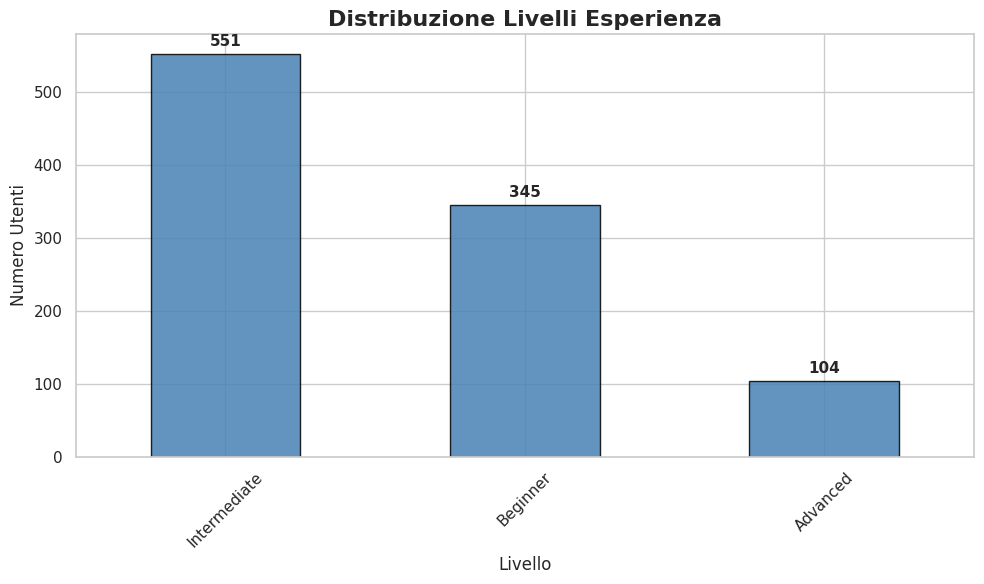


Imbalance ratio (min/max): 0.189
 - Dataset sbilanciato: la classe minoritaria può avere recall instabile
 - Soluzione: usare stratified split e monitorare metriche per-classe


In [72]:
print("="*70)
print("TARGET: experience_label")
print("="*70)

target_counts = df_users['experience_label'].value_counts()
print("\nConteggi assoluti:")
print(target_counts)

print("\nPercentuali:")
for level, count in target_counts.items():
    pct = count / len(df_users) * 100
    print(f"  {level:15} {count:>4} ({pct:>5.1f}%)")

# Grafico
fig, ax = plt.subplots(figsize=(10, 6))
target_counts.plot(kind='bar', ax=ax, color='steelblue', alpha=0.85, edgecolor='black')
ax.set_title('Distribuzione Livelli Esperienza', fontsize=16, fontweight='bold')
ax.set_xlabel('Livello', fontsize=12)
ax.set_ylabel('Numero Utenti', fontsize=12)
ax.tick_params(axis='x', rotation=45)

# Aggiungi valori sopra le barre
for i, v in enumerate(target_counts.values):
    ax.text(i, v + max(target_counts.values)*0.02, str(v),
            ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Calcolo imbalance ratio
imbalance_ratio = target_counts.min() / target_counts.max()
print(f"\nImbalance ratio (min/max): {imbalance_ratio:.3f}")

if imbalance_ratio < 0.5:
    print(" - Dataset sbilanciato: la classe minoritaria può avere recall instabile")
    print(" - Soluzione: usare stratified split e monitorare metriche per-classe")
else:
    print(" Dataset relativamente bilanciato")


---
##3. **EDA Feature "Raw" da** `workout_logs`

Analizziamo le feature **prima** di qualsiasi aggregazione per capire i segnali disponibili.

### **Feature considerate (potenzialmente utili)**:
- `loaddonekg`: carico sollevato (kg)
- `rpedone`: RPE (Rate of Perceived Exertion, scala 1-10)
- `setsdone`: numero set eseguiti
- `repsdoneavg`: ripetizioni medie per set
- `repsdonetotal`: ripetizioni totali
- `gapadherencescore`: aderenza al piano (1.0 = perfetto)


In [59]:
raw_feats = ['loaddonekg', 'rpedone', 'setsdone', 'repsdoneavg',
             'repsdonetotal', 'gapadherencescore']

print("="*70)
print("STATISTICHE DESCRITTIVE - FEATURE RAW")
print("="*70)

for f in raw_feats:
    if f in df_logs.columns:
        print(f"\n{f}:")
        print(df_logs[f].describe())
    else:
        print(f"\n{f}: ✗ NON TROVATA")


STATISTICHE DESCRITTIVE - FEATURE RAW

loaddonekg:
count    548299.000000
mean         51.201545
std          19.263938
min          12.500000
25%          36.620000
50%          48.500000
75%          63.000000
max         200.500000
Name: loaddonekg, dtype: float64

rpedone:
count    547258.000000
mean          8.074525
std           0.657655
min           4.500000
25%           7.620000
50%           8.000000
75%           8.500000
max          10.000000
Name: rpedone, dtype: float64

setsdone:
count    549282.000000
mean          2.551180
std           1.184569
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           8.000000
Name: setsdone, dtype: float64

repsdoneavg:
count    549282.000000
mean          9.454024
std           3.363738
min           1.000000
25%           7.000000
50%           9.330000
75%          12.000000
max          23.000000
Name: repsdoneavg, dtype: float64

repsdonetotal:
count    549282.000000
mean       

### **Distribuzione Feature Raw (Istogrammi)**

Obiettivo: capire range, outlier, forma della distribuzione.


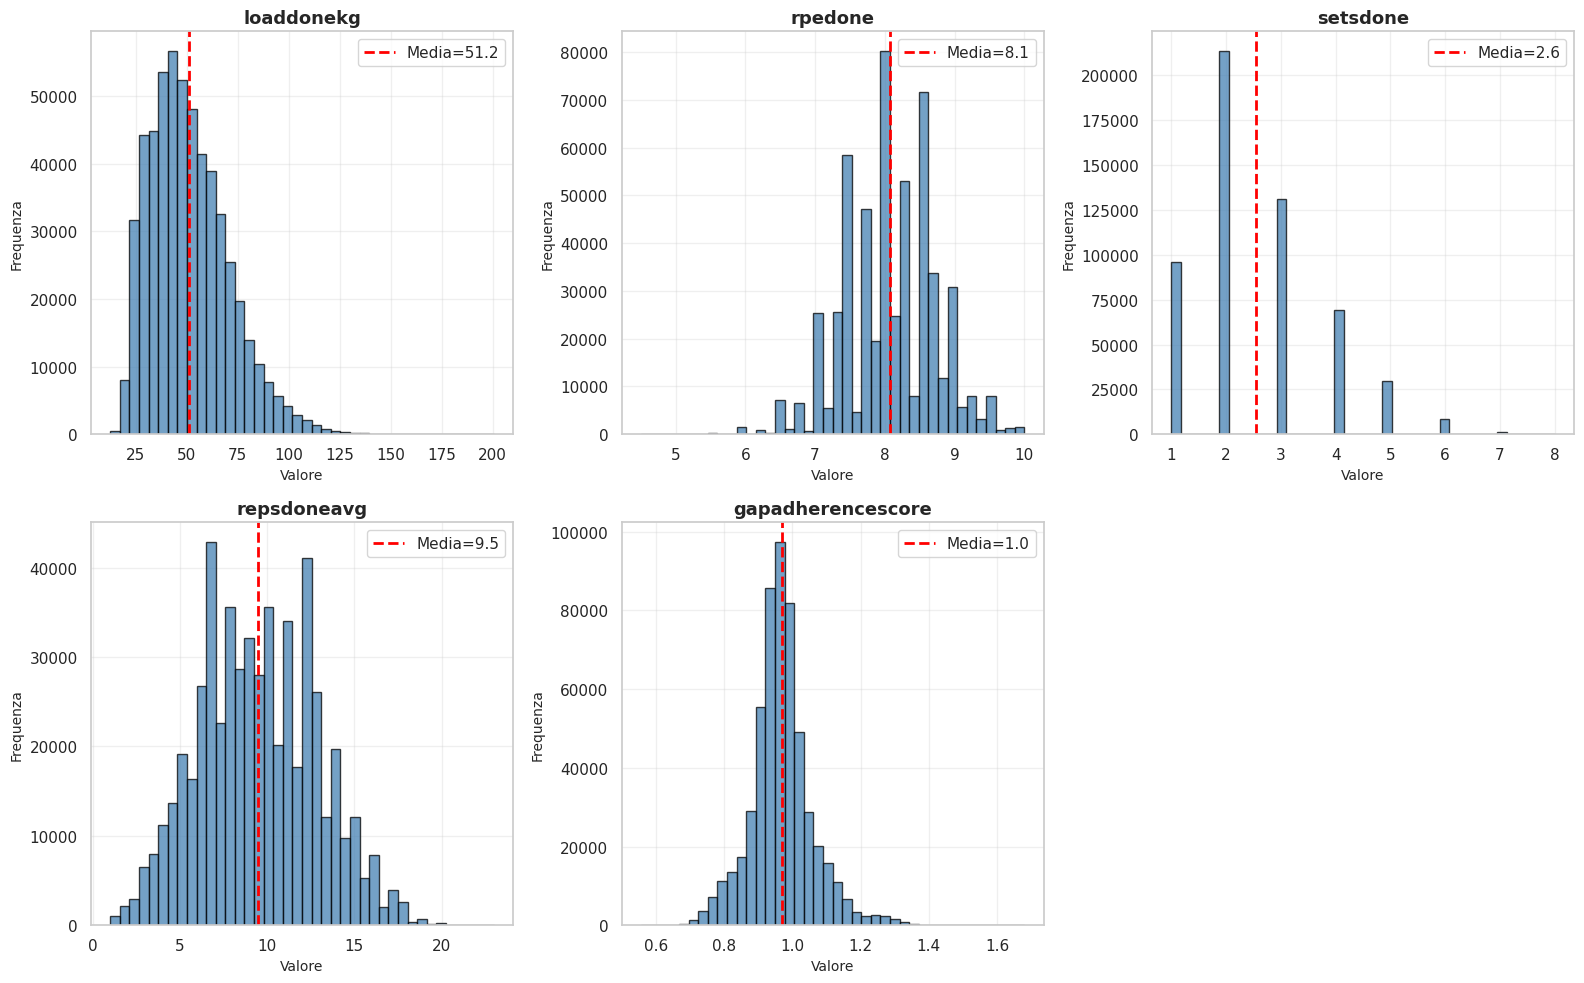

In [60]:
feats_plot = ['loaddonekg', 'rpedone', 'setsdone', 'repsdoneavg', 'gapadherencescore']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, f in enumerate(feats_plot):
    if f in df_logs.columns:
        data = df_logs[f].dropna()
        axes[i].hist(data, bins=40, color='steelblue', alpha=0.75, edgecolor='black')
        axes[i].set_title(f, fontsize=13, fontweight='bold')
        axes[i].set_xlabel('Valore', fontsize=10)
        axes[i].set_ylabel('Frequenza', fontsize=10)
        axes[i].grid(alpha=0.3)

        # Aggiungi media come linea verticale
        mean_val = data.mean()
        axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2,
                        label=f'Media={mean_val:.1f}')
        axes[i].legend()

axes[-1].axis('off')
plt.tight_layout()
plt.show()


---
##4. **Feature Raw per Livello (Boxplot)**

**Domanda chiave**: le feature raw separano già i livelli *prima* di aggregare per utente?

**Come leggere i boxplot:**
- Box ben separati → segnale forte
- Box sovrapposti → segnale debole (ma può migliorare dopo aggregazione)


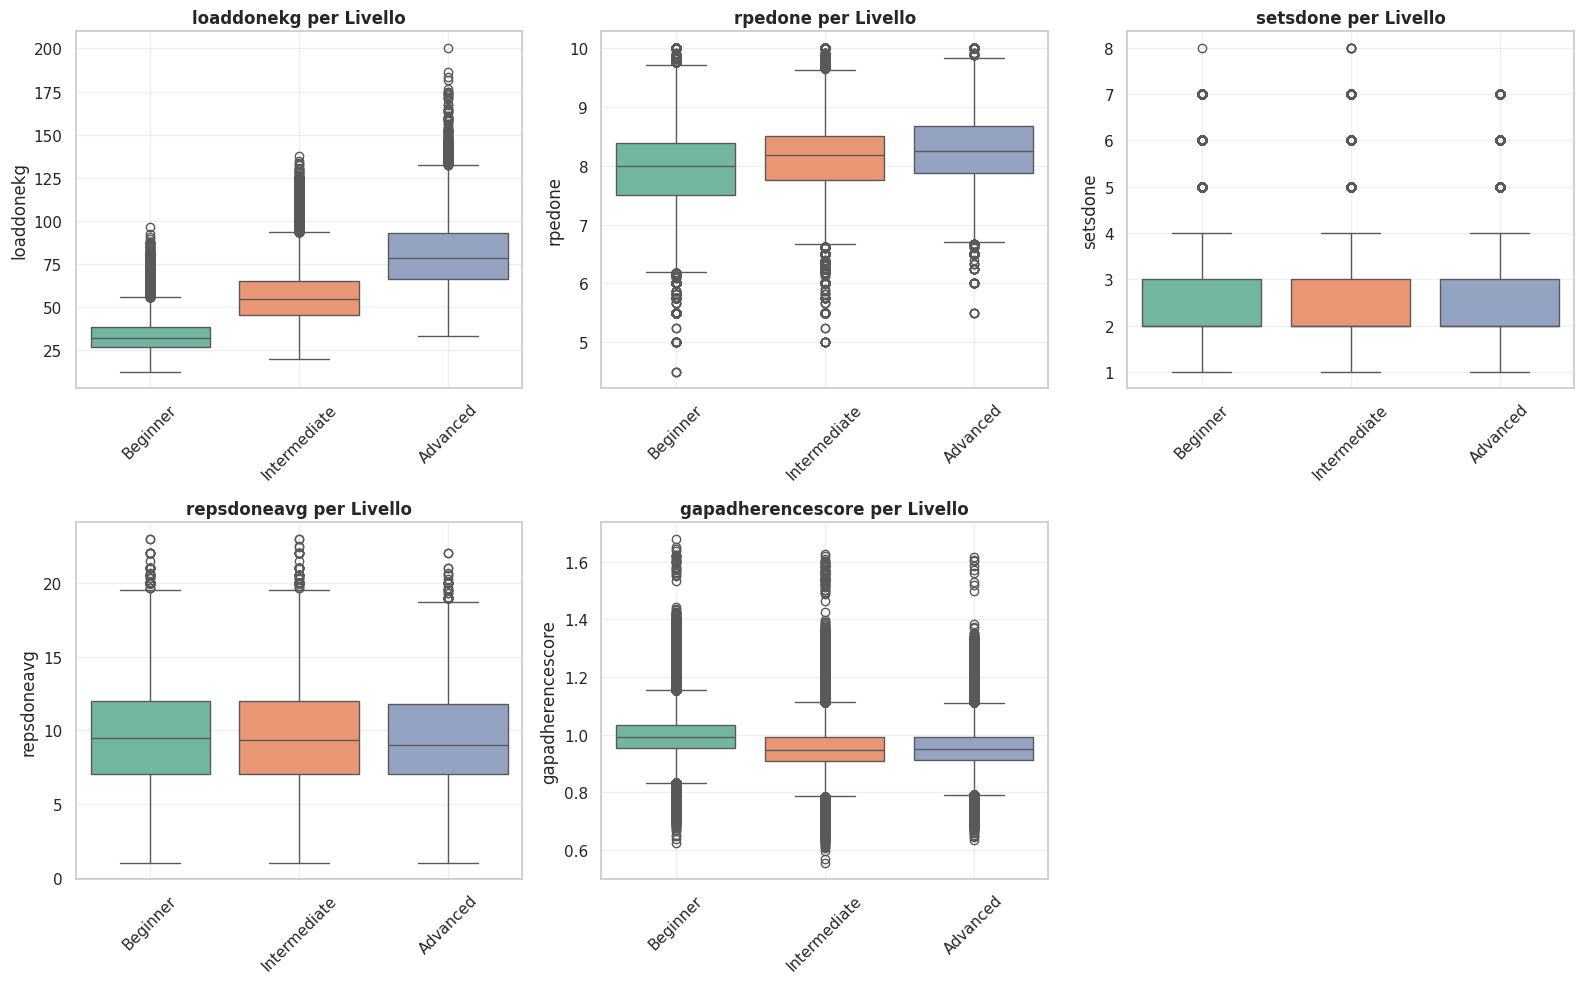


INTERPRETAZIONE:
 - loaddonekg: se Advanced > Intermediate > Beginner → segnale forte
 - gapadherencescore: se Advanced più costante → segnale utile
 - rpedone: se molto sovrapposto → segnale debole da solo


In [61]:
# Merge label sui log
logs_labeled = df_logs.merge(df_users[['userid', 'experience_label']],
                              on='userid', how='left')

feats_by_level = ['loaddonekg', 'rpedone', 'setsdone', 'repsdoneavg', 'gapadherencescore']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, f in enumerate(feats_by_level):
    sns.boxplot(data=logs_labeled, x='experience_label', y=f, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{f} per Livello', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(alpha=0.3)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

print("\nINTERPRETAZIONE:")
print(" - loaddonekg: se Advanced > Intermediate > Beginner → segnale forte")
print(" - gapadherencescore: se Advanced più costante → segnale utile")
print(" - rpedone: se molto sovrapposto → segnale debole da solo")


---
##5. **Qualità Dati: Missing Values**

Verifichiamo se ci sono dati mancanti che possono influenzare l'analisi.


In [62]:
print("="*70)
print("MISSING VALUES")
print("="*70)

for name, df in [('users', df_users), ('workout_logs', df_logs), ('workouts', df_workouts)]:
    miss = df.isna().sum()
    miss = miss[miss > 0].sort_values(ascending=False)

    print(f"\n{name}:")
    if len(miss) == 0:
        print(" - Nessun valore mancante")
    else:
        out = pd.DataFrame({
            'count': miss,
            'pct': (miss / len(df) * 100).round(2)
        })
        print(out.to_string())


MISSING VALUES

users:
 - Nessun valore mancante

workout_logs:
            count   pct
rpedone      2024  0.37
loaddonekg    983  0.18

workouts:
 - Nessun valore mancante


---
## 6. **Sessioni: Done vs Skipped**

Il comportamento di skip è un **segnale comportamentale** importante:
- Beginner tendono a saltare più sessioni (meno costanza)
- Advanced più consistenti


WORKOUT STATUS

Conteggi:
workoutstatus
done       152185
skipped     17107
Name: count, dtype: int64

Percentuali:
  done       152185 ( 89.9%)
  skipped     17107 ( 10.1%)


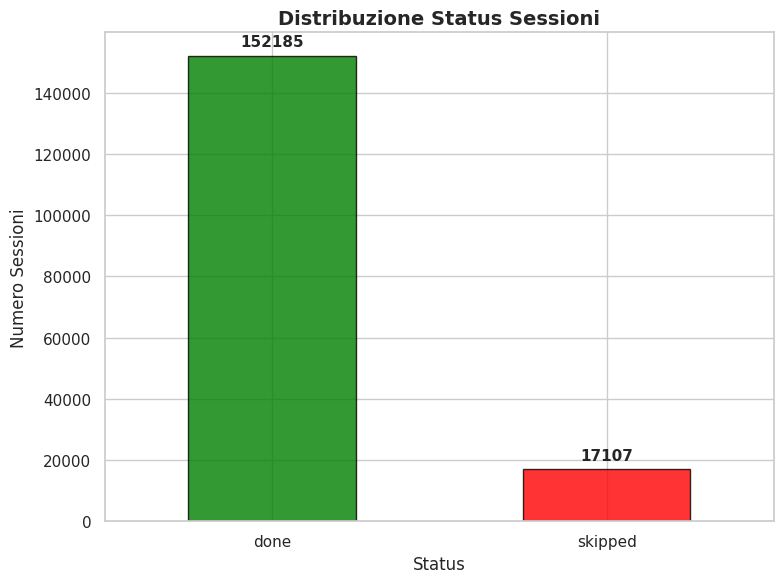

In [63]:
print("="*70)
print("WORKOUT STATUS")
print("="*70)

status_counts = df_workouts['workoutstatus'].value_counts()
print("\nConteggi:")
print(status_counts)

print("\nPercentuali:")
for status, count in status_counts.items():
    pct = count / len(df_workouts) * 100
    print(f"  {status:10} {count:>6} ({pct:>5.1f}%)")

# Grafico
fig, ax = plt.subplots(figsize=(8, 6))
status_counts.plot(kind='bar', ax=ax, color=['green', 'red'], alpha=0.8, edgecolor='black')
ax.set_title('Distribuzione Status Sessioni', fontsize=14, fontweight='bold')
ax.set_xlabel('Status', fontsize=12)
ax.set_ylabel('Numero Sessioni', fontsize=12)
ax.tick_params(axis='x', rotation=0)

for i, v in enumerate(status_counts.values):
    ax.text(i, v + max(status_counts.values)*0.02, str(v),
            ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


### **Skip Rate per Livello**

Calcoliamo la percentuale di sessioni saltate per ogni livello di esperienza.


SKIP RATE (%) PER LIVELLO
experience_label
Beginner        13.16
Intermediate     8.76
Advanced         7.10
Name: is_skipped, dtype: float64


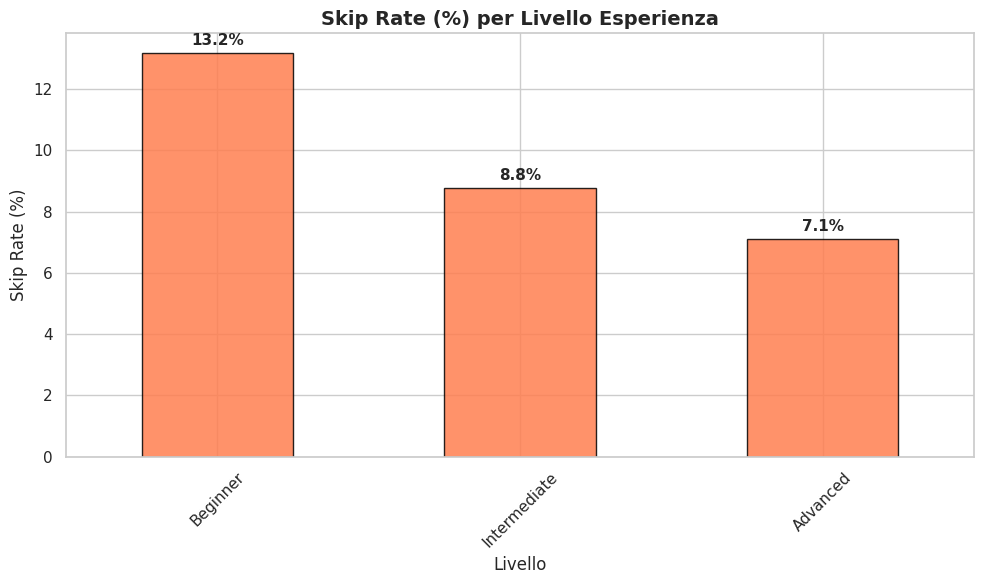


 INTERPRETAZIONE:
 - CI ASPETTIAMO: Beginner > Intermediate > Advanced
   (principianti meno costanti)

Trend confermato!


In [64]:
# Calcolo skip rate per livello (evita warning deprecation)
df_tmp = df_workouts.copy()
df_tmp['is_skipped'] = (df_tmp['workoutstatus'] == 'skipped').astype(int)

skip_by_level = df_tmp.groupby('experience_label')['is_skipped'].mean().sort_values(ascending=False) * 100

print("="*70)
print("SKIP RATE (%) PER LIVELLO")
print("="*70)
print(skip_by_level.round(2))

# Grafico
fig, ax = plt.subplots(figsize=(10, 6))
skip_by_level.plot(kind='bar', ax=ax, color='coral', alpha=0.85, edgecolor='black')
ax.set_title('Skip Rate (%) per Livello Esperienza', fontsize=14, fontweight='bold')
ax.set_xlabel('Livello', fontsize=12)
ax.set_ylabel('Skip Rate (%)', fontsize=12)
ax.tick_params(axis='x', rotation=45)

for i, v in enumerate(skip_by_level.values):
    ax.text(i, v + skip_by_level.max()*0.02, f'{v:.1f}%',
            ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n INTERPRETAZIONE:")
print(" - CI ASPETTIAMO: Beginner > Intermediate > Advanced")
print("   (principianti meno costanti)")

if skip_by_level.iloc[0] > skip_by_level.iloc[-1]:
    print("\nTrend confermato!")
else:
    print("\nTrend inatteso (da investigare)")


---
## 7. **Outlier Detection (IQR Method)**

Non facciamo pulizia automatica, ma verifichiamo se esistono code lunghe che possono distorcere le statistiche.

**Metodo IQR:**
- Range normale: [Q1 - 1.5×IQR, Q3 + 1.5×IQR]
- Valori fuori range = outlier potenziali


In [65]:
def iqr_outliers(series):
    s = series.dropna()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo = q1 - 1.5 * iqr
    hi = q3 + 1.5 * iqr
    out_pct = ((s < lo) | (s > hi)).mean() * 100
    return lo, hi, out_pct, s.min(), s.max()

print("="*70)
print("OUTLIER ANALYSIS (IQR)")
print("="*70)

for f in ['loaddonekg', 'rpedone', 'gapadherencescore']:
    lo, hi, out_pct, mn, mx = iqr_outliers(df_logs[f])
    print(f"\n{f}:")
    print(f"  Range IQR:  [{lo:.2f}, {hi:.2f}]")
    print(f"  Min/Max:    {mn:.2f} / {mx:.2f}")
    print(f"  Outliers:   {out_pct:.2f}%")

    if out_pct > 10:
        print(f"   Molti outlier (>{out_pct:.0f}%)")
    else:
        print(f"  Outlier sotto controllo")


OUTLIER ANALYSIS (IQR)

loaddonekg:
  Range IQR:  [-2.95, 102.57]
  Min/Max:    12.50 / 200.50
  Outliers:   1.43%
  Outlier sotto controllo

rpedone:
  Range IQR:  [6.30, 9.82]
  Min/Max:    4.50 / 10.00
  Outliers:   0.81%
  Outlier sotto controllo

gapadherencescore:
  Range IQR:  [0.79, 1.14]
  Min/Max:    0.56 / 1.68
  Outliers:   6.61%
  Outlier sotto controllo


### 9. **Correlazioni tra Feature - Heatmap**

Analizziamo le correlazioni lineari (Pearson) tra le feature numeriche aggregate per capire:
- Quali feature sono ridondanti (correlazione alta)
- Quali potrebbero essere predittori interessanti per il target
- Eventuali relazioni controintuitive da investigare


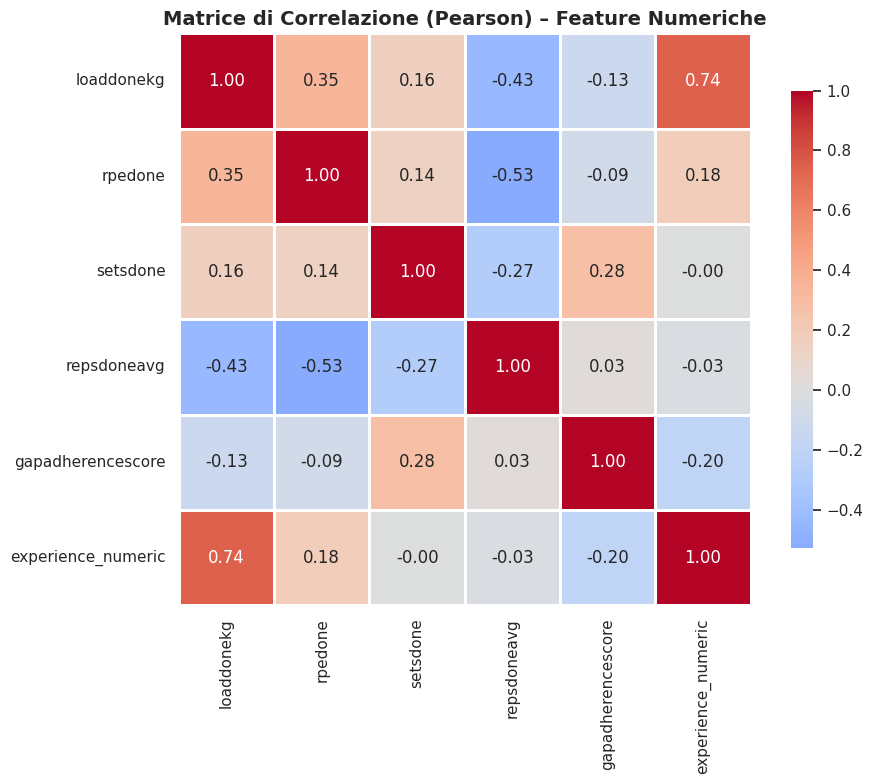


TOP CORRELAZIONI (in valore assoluto, esclusa diagonale)
experience_numeric  loaddonekg           0.741812
repsdoneavg         rpedone             -0.525646
                    loaddonekg          -0.428427
rpedone             loaddonekg           0.349040
gapadherencescore   setsdone             0.284950
repsdoneavg         setsdone            -0.269991
experience_numeric  gapadherencescore   -0.196429
                    rpedone              0.180475
setsdone            loaddonekg           0.156379
                    rpedone              0.137326
dtype: float64

INTERPRETAZIONE

- **RPE vs Load/Sets**: se correlazione alta → fatica percepita riflette carico oggettivo
- **Gap Adherence vs Experience**: se negativa → principianti fanno più fatica ad aderire al piano
- **Load vs Experience**: se positiva → utenti avanzati sollevano carichi più pesanti (atteso)
- **Correlazioni < 0.3**: praticamente assenti, feature indipendenti



In [75]:
# ===== CORRELAZIONI TRA FEATURE NUMERICHE =====

# Verifica che df_logs_labeled esista
if 'df_logs_labeled' not in dir():
    print(" Creo df_logs_labeled...")
    df_logs_labeled = df_logs.merge(
        df_users[['userid', 'experience_label']],
        on='userid',
        how='left'
    )

# 1. Prepara dataset per correlazioni (solo numeriche)
numeric_cols = [
    'loaddonekg', 'rpedone', 'setsdone', 'repsdoneavg', 'gapadherencescore'
]

# Mappa experience_label a numerico per includerla nella correlazione
label_map = {'Beginner': 0, 'Intermediate': 1, 'Advanced': 2}
df_logs_labeled['experience_numeric'] = df_logs_labeled['experience_label'].map(label_map)

# Seleziona solo colonne numeriche valide
corr_cols = numeric_cols + ['experience_numeric']
df_corr = df_logs_labeled[corr_cols].dropna()

# 2. Calcola matrice di correlazione
corr_matrix = df_corr.corr()

# 3. Plot: Heatmap completa
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,          # mostra valori numerici
    fmt='.2f',           # 2 decimali
    cmap='coolwarm',     # scala colori: rosso = correlazione positiva, blu = negativa
    center=0,            # centra lo zero
    square=True,         # celle quadrate
    linewidths=1,
    cbar_kws={'shrink': 0.8},
    ax=ax
)
ax.set_title('Matrice di Correlazione (Pearson) – Feature Numeriche', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 4. Estrai top correlazioni (esclusa diagonale)
print("\n" + "="*70)
print("TOP CORRELAZIONI (in valore assoluto, esclusa diagonale)")
print("="*70)

# Estrai triangolo superiore (senza diagonale)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_flat = corr_matrix.where(~mask).stack().sort_values(key=abs, ascending=False)

# Mostra top 10
print(corr_flat.head(10))

# 5. Commento interpretativo
print("\n" + "="*70)
print("INTERPRETAZIONE")
print("="*70)
print("""
- **RPE vs Load/Sets**: se correlazione alta → fatica percepita riflette carico oggettivo
- **Gap Adherence vs Experience**: se negativa → principianti fanno più fatica ad aderire al piano
- **Load vs Experience**: se positiva → utenti avanzati sollevano carichi più pesanti (atteso)
- **Correlazioni < 0.3**: praticamente assenti, feature indipendenti
""")


### 9. **Pairplot (Scatter Matrix) - Relazioni Non Lineari**

Il pairplot mostra:
- **Diagonale**: distribuzione di ogni feature (KDE)
- **Off-diagonale**: scatter plot tra coppie di feature, colorati per livello esperienza
- Utile per individuare pattern non lineari che la correlazione di Pearson non cattura


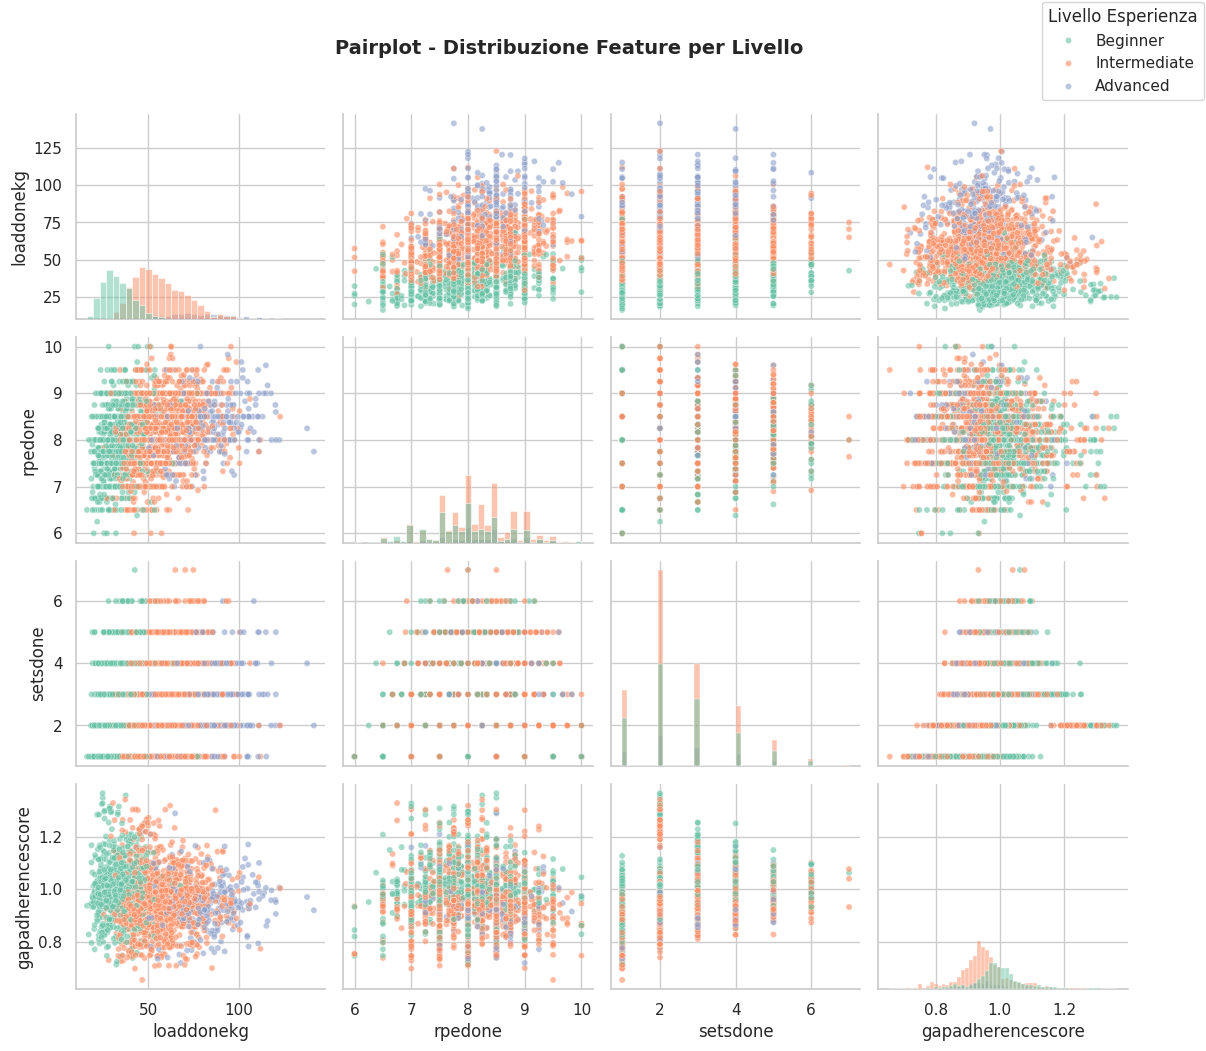


 INTERPRETAZIONE:
- Diagonale: distribuzione di ogni feature
- Off-diagonal: scatter plot tra coppie di feature
- Colori: Advanced (verde), Intermediate (arancione), Beginner (blu)
- Cerchiamo separazione tra colori → feature discriminanti


In [68]:
# === PAIRPLOT (SCATTER MATRIX) ===

# Verifica che df_logs_labeled esista
if 'df_logs_labeled' not in dir():
    df_logs_labeled = df_logs.merge(
        df_users[['userid', 'experience_label']],
        on='userid',
        how='left'
    )

# Feature da plottare (NOMI CORRETTI, max 4-5 per leggibilità)
feats_pair = ['loaddonekg', 'rpedone', 'setsdone', 'gapadherencescore']

# Sampling aggressivo per pairplot (3k righe)
sample_size = min(3000, len(df_logs_labeled))
df_sample = df_logs_labeled[feats_pair + ['experience_label']].sample(
    n=sample_size, random_state=42
)

# Pairplot con hue per livello esperienza
g = sns.pairplot(
    df_sample,
    hue='experience_label',
    palette='Set2',
    diag_kind='hist',
    plot_kws={'alpha': 0.6, 's': 20},
    height=2.5
)

# SPOSTA LA LEGENDA FUORI DAL GRAFICO (in alto a destra)
g._legend.set_bbox_to_anchor((1.05, 1))  # Posizione: fuori, centrata verticalmente
g._legend.set_title('Livello Esperienza')  # Titolo più chiaro
g._legend.set_frame_on(True)  # Cornice attorno alla legenda

# Titolo generale
plt.suptitle('Pairplot - Distribuzione Feature per Livello', y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n INTERPRETAZIONE:")
print("- Diagonale: distribuzione di ogni feature")
print("- Off-diagonal: scatter plot tra coppie di feature")
print("- Colori: Advanced (verde), Intermediate (arancione), Beginner (blu)")
print("- Cerchiamo separazione tra colori → feature discriminanti")


---
---

# **FEATURE CANDIDATE MA SCARTATE**

Questa sezione analizza feature che **potrebbero sembrare utili** ma che **non useremo** nel modello STATUS per motivi di:

- **Leakage**: troppo vicine al modo in cui è stato generato il target
- **Non osservabilità**: parametri interni del simulatore, non disponibili in app reale
- **Segnale debole**: distribuzioni troppo sovrapposte tra livelli

---


## A) **Parametri "Interni" dell'Utente (users.csv)**

### **Feature candidate**:
- `experience_latent`: valore latente di esperienza (usato per generare il target)
- `alpha_adapt`: tasso di adattamento
- `k_detraining`: coefficiente detraining
- `obs_noise`: rumore osservazionale
- `resilience`: resilienza
- `fatigue_sens`: sensibilità alla fatica
- `rpe_report_bias`: bias nel report RPE

### **Problema**: LEAKAGE + NON OSSERVABILITÀ

Queste variabili sono **parametri del simulatore** o **latent variables** usate per generare il dataset.

**In un'app reale:**
- Non sono direttamente osservabili dai log
- Usarle introdurrebbe leakage (il modello impara il meccanismo di generazione, non il comportamento)


ANALISI FEATURE INTERNE (users.csv)

Feature trovate: 7
['experience_latent', 'alpha_adapt', 'k_detraining', 'obs_noise', 'resilience', 'fatigue_sens', 'rpe_report_bias']


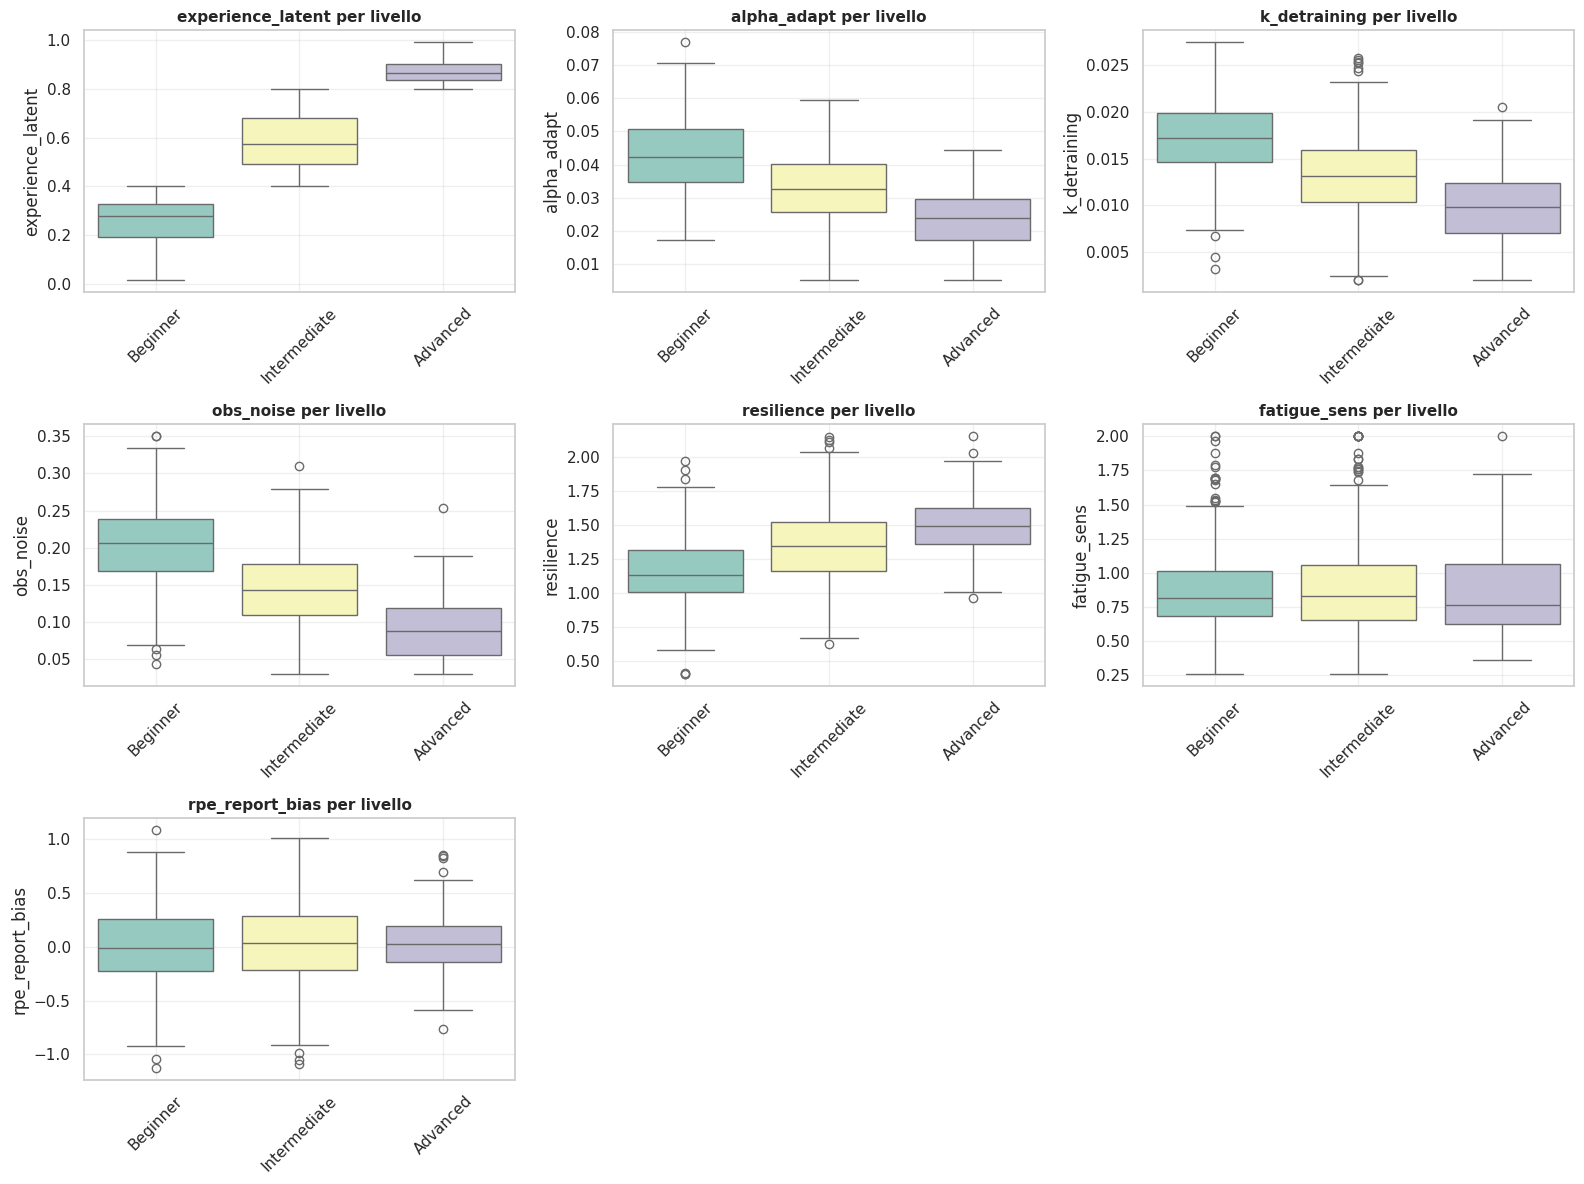


 OSSERVAZIONE:
  - Alcune separano bene i livelli (es. experience_latent)
  - MA: non sono osservabili in produzione → SCARTATE


In [69]:
internal_feats = [
    'experience_latent', 'alpha_adapt', 'k_detraining', 'obs_noise',
    'resilience', 'fatigue_sens', 'rpe_report_bias'
]
internal_feats = [c for c in internal_feats if c in df_users.columns]

print("="*70)
print("ANALISI FEATURE INTERNE (users.csv)")
print("="*70)
print(f"\nFeature trovate: {len(internal_feats)}")
print(internal_feats)

if internal_feats:
    import math
    cols = 3
    rows = math.ceil(len(internal_feats) / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    axes = np.array(axes).flatten()

    for i, f in enumerate(internal_feats):
        sns.boxplot(data=df_users, x='experience_label', y=f, ax=axes[i], palette='Set3')
        axes[i].set_title(f'{f} per livello', fontsize=11, fontweight='bold')
        axes[i].set_xlabel('')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(alpha=0.3)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    print("\n OSSERVAZIONE:")
    print("  - Alcune separano bene i livelli (es. experience_latent)")
    print("  - MA: non sono osservabili in produzione → SCARTATE")
else:
    print("\n Nessuna feature interna trovata (dataset già pulito)")


### **DECISIONE: SCARTATE**

**Motivo:**
1. Non disponibili in un contesto reale (parametri interni)
2. Rischio leakage (troppo vicine alla generazione del target)
3. Vogliamo un modello basato su **segnali osservabili**: carico, volume, aderenza, skip rate


---
## B) **Feature "Planned" della Sessione (workout_logs)**

### Feature candidate:
- `loadintendedkg`: carico previsto dal piano
- `setsplanned`: set previsti
- `reps_target_avg`: ripetizioni target
- `repsmin`, `repsmax`: range ripetizioni previsto
- `rirtarget`: RIR (Reps In Reserve) target

### **Problema**: PROGRAM LEAKAGE

Queste feature descrivono **la scheda assegnata**, non la performance reale.

**Rischio:**
Se il programma è costruito diversamente per livello (es. Advanced riceve schede più intense), il modello impara a riconoscere **lo stile del piano** invece del comportamento dell'utente.


ANALISI FEATURE 'PLANNED' (workout_logs)

Feature trovate: 6
['loadintendedkg', 'setsplanned', 'reps_target_avg', 'repsmin', 'repsmax', 'rirtarget']


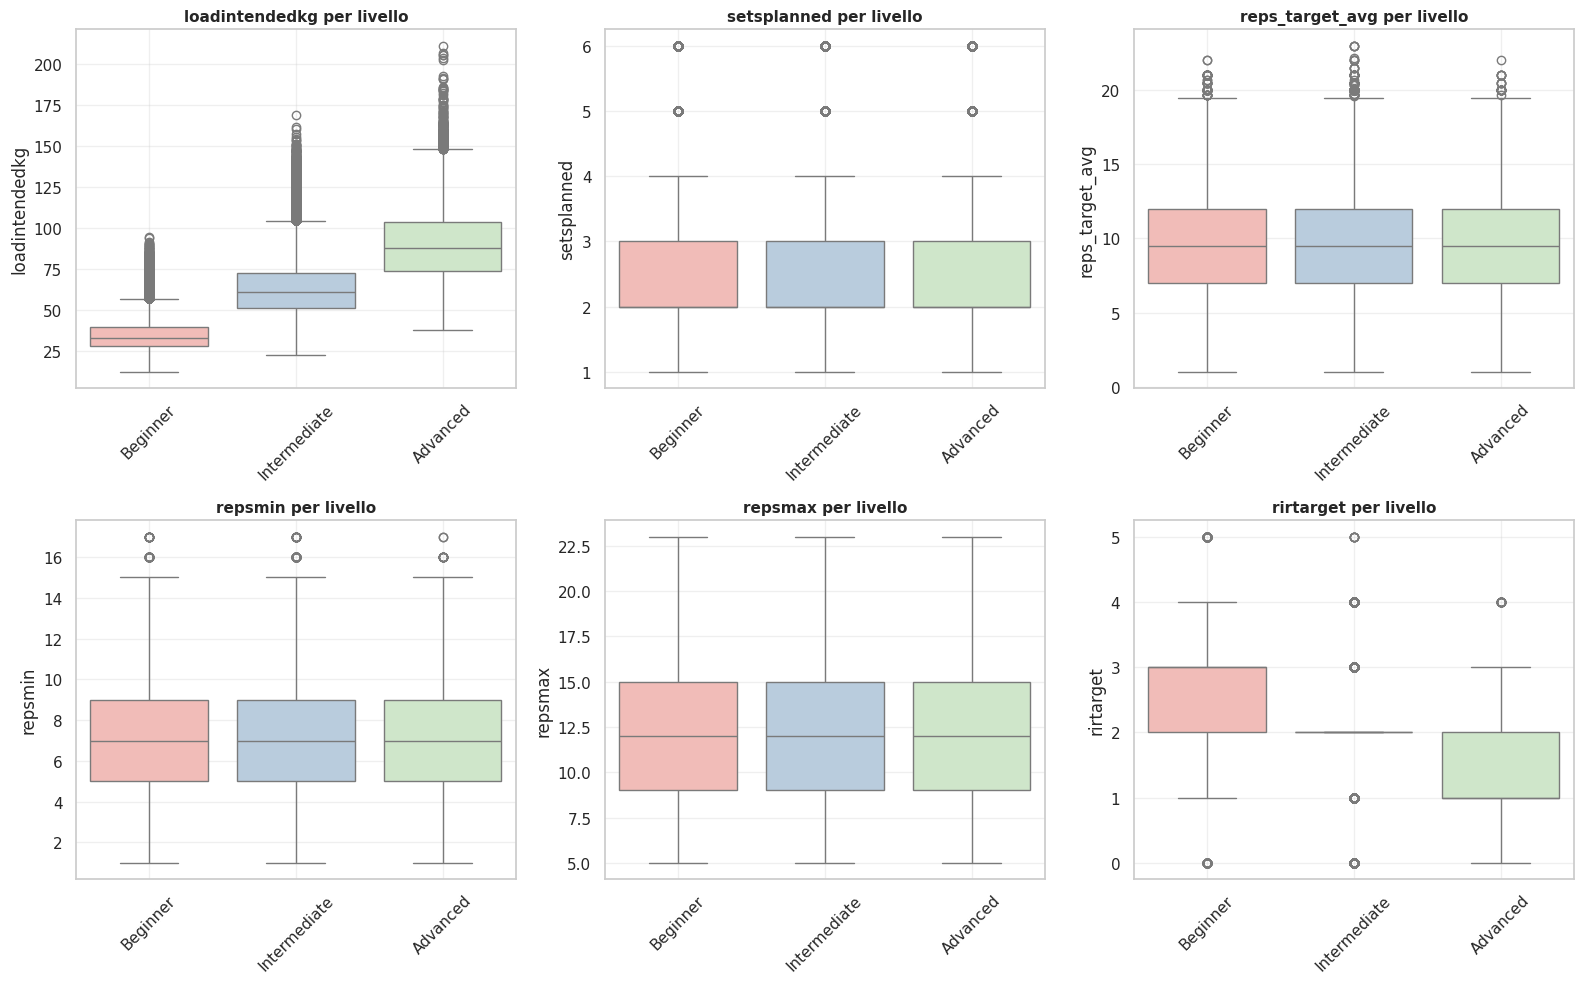


 OSSERVAZIONE:
  - Se le schede sono diverse per livello, queste feature separano TROPPO bene
  - Rischio: predire il livello dalla SCHEDA, non dalla PERFORMANCE


In [70]:
planned_feats = [
    'loadintendedkg', 'setsplanned', 'reps_target_avg',
    'repsmin', 'repsmax', 'rirtarget'
]
planned_feats = [c for c in planned_feats if c in df_logs.columns]

print("="*70)
print("ANALISI FEATURE 'PLANNED' (workout_logs)")
print("="*70)
print(f"\nFeature trovate: {len(planned_feats)}")
print(planned_feats)

if planned_feats:
    logs_lab = df_logs.merge(df_users[['userid', 'experience_label']],
                              on='userid', how='left')

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()

    for i, f in enumerate(planned_feats[:6]):
        sns.boxplot(data=logs_lab, x='experience_label', y=f, ax=axes[i], palette='Pastel1')
        axes[i].set_title(f'{f} per livello', fontsize=11, fontweight='bold')
        axes[i].set_xlabel('')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(alpha=0.3)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    print("\n OSSERVAZIONE:")
    print("  - Se le schede sono diverse per livello, queste feature separano TROPPO bene")
    print("  - Rischio: predire il livello dalla SCHEDA, non dalla PERFORMANCE")
else:
    print("\n Nessuna feature 'planned' trovata")


### **DECISIONE: SCARTATE**

**Motivo:**
1. Classificano il **programma assegnato**, non il comportamento
2. In STATUS vogliamo predire il livello da segnali osservabili post-esecuzione
3. Possono essere usate in un'analisi separata ("program effectiveness") ma non qui


---
## C) **Feature con Segnale Debole: RPE**

### **Feature**: `rpedone` (Rate of Perceived Exertion)

**Idea teorica:**
RPE misura lo sforzo percepito (1-10). Potrebbe separare livelli se Advanced allenavano a RPE più alte.

**Problema pratico:**
Tutti possono allenarsi "a RPE 8", indipendentemente dal livello. La distribuzione tende ad essere molto sovrapposta.


ANALISI RPE (segnale debole)


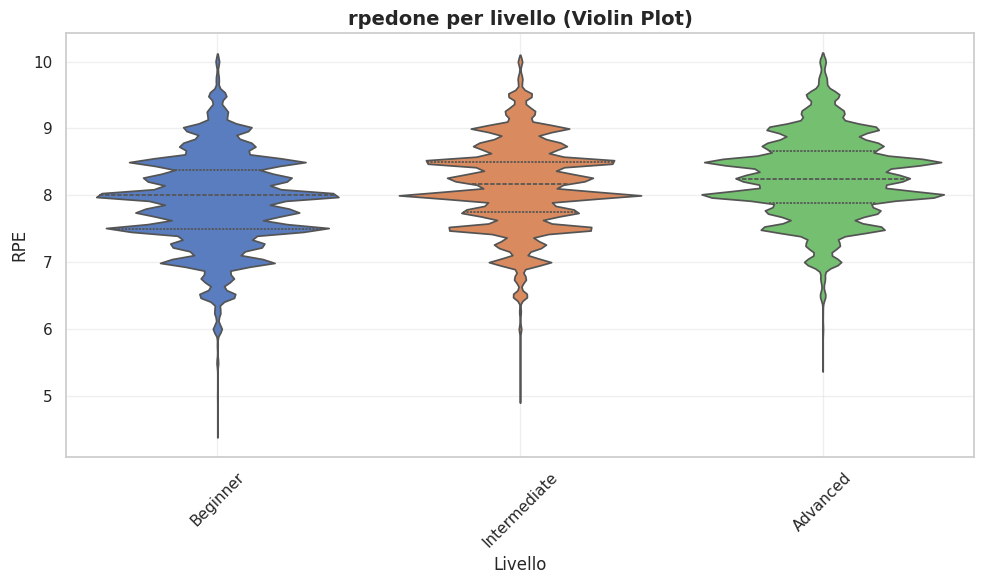


Statistiche RPE per livello:
                      mean       std
experience_label                    
Advanced          8.262325  0.598886
Beginner          7.911008  0.674183
Intermediate      8.135722  0.638266

Differenza media max-min: 0.351
   Differenza troppo piccola (<0.5) -> segnale debole


In [71]:
print("="*70)
print("ANALISI RPE (segnale debole)")
print("="*70)

if 'rpedone' in logs_labeled.columns:
    # Violin plot (mostra densità meglio del boxplot)
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=logs_labeled, x='experience_label', y='rpedone',
                   inner='quartile', palette='muted')
    plt.title('rpedone per livello (Violin Plot)', fontsize=14, fontweight='bold')
    plt.xlabel('Livello', fontsize=12)
    plt.ylabel('RPE', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Statistiche per livello
    rpe_stats = logs_labeled.groupby('experience_label')['rpedone'].agg(['mean', 'std'])
    print("\nStatistiche RPE per livello:")
    print(rpe_stats)

    mean_diff = rpe_stats['mean'].max() - rpe_stats['mean'].min()
    print(f"\nDifferenza media max-min: {mean_diff:.3f}")

    if mean_diff < 0.5:
        print("   Differenza troppo piccola (<0.5) -> segnale debole")
    else:
        print("  Differenza significativa")
else:
    print("\n rpedone non trovata")


### **DECISIONE: SECONDARIA (uso limitato)**

**Motivo:**
1. Separazione tra livelli molto debole (distribuzioni sovrapposte)
2. Può rimanere come **feature di supporto** combinata con carico/volume
3. Ma non è una feature "primaria" per spiegabilità


---
---

# **RIEPILOGO DECISIONI FEATURE**

## **Feature TENUTE (usate nel Feature Engineering)**

| Feature | Fonte | Motivazione |
|---------|-------|-------------|
| `loaddonekg` | workout_logs | Segnale diretto di performance (carico sollevato) |
| `repsdonetotal`, `repsdoneavg` | workout_logs | Volume eseguito (quanto lavoro) |
| `setsdone` | workout_logs | Quantità lavoro |
| `gapadherencescore` | workout_logs | Aderenza al piano (qualità esecuzione) |
| `workoutstatus` → skip_rate | workouts | Segnale comportamentale (costanza) |

---

## **Feature SCARTATE**

| Feature | Motivo Scarto |
|---------|---------------|
| Parametri interni (experience_latent, alpha_adapt, ...) | Non osservabili / Leakage |
| Planned (loadintendedkg, setsplanned, ...) | Program leakage (classificano la scheda) |
| RPE | Segnale troppo debole (distribuzioni sovrapposte) |
